## 1. Метод главных компонент (PCA)

![clown.png](attachment:clown.png)

### Интуиция, теория и особенности применения

Метод главных компонент (Principal Component Analysis) — один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков.

<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">

В совсем общем виде это можно представить как предположение о том, что все наши наблюдения скорее всего выглядят как некий эллипсоид в подпространстве нашего исходного пространства и наш новый базис в этом пространстве совпадает с осями этого эллипсоида. Это предположение позволяет нам одновременно избавиться от сильно скоррелированных признаков, так как вектора базиса пространства, на которое мы проецируем, будут ортогональными.

В общем случае размерность этого эллипсоида будет равна размерности исходного пространства, но наше предположение о том, что данные лежат в подпространстве меньшей размерности, позволяет нам отбросить "лишнее" подпространство в новой проекции, а именно то подпространство, вдоль осей которого эллипсоид будет наименее растянут. Мы будем это делать "жадно", выбирая по-очереди в качестве нового элемента базиса нашего нового подпространства последовательно ось эллипсоида из оставшихся, вдоль которой дисперсия будет максимальной.

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton

Рассмотрим как это делается математически:

Чтобы снизить размерность наших данных из $n$ в $k, k \leq n$, нам нужно выбрать топ-$k$ осей такого эллипсоида, отсортированные по убыванию по дисперсии вдоль осей.

Начнём с того, что посчитаем дисперсии и ковариации исходных признаков. Это делается просто с помощью матрицы ковариации. По определению ковариации, для двух признаков $X_i$ и $X_j$ их ковариация будет
$$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j$$
где $\mu_i$ — матожидание $i$-ого признака.
При этом отметим, что ковариация симметрична и ковариация вектора с самим собой будет равна его дисперсии.

Таким образом матрица ковариации представляет собой симметричную матрицу, где на диагонали лежат дисперсии соответствующих признаков, а вне диагонали — ковариации соответствующих пар признаков. В матричном виде, где $\mathbf{X}$ это матрица наблюдений, наша матрица ковариации будет выглядеть как
$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Чтобы освежить память — у матриц как у линейных операторов есть такое интересное свойство как собственные значения и собственные вектора (eigenvalues и eigenvectors). Эти штуки замечательны тем, что когда мы нашей матрицей действуем на соответствующее линейное пространство, собственные вектора остаются на месте и лишь умножаются на соответствующие им собственные значения. То есть определяют подпространство, которое при действии этой матрицей как линейным оператором, остаётся на месте или "переходит в себя". Формально собственный вектор $w_i$ с собственным значением $\lambda_i$ для матрицы $M$ определяется просто как $M w_i = \lambda_i w_i$.

Матрицу ковариации для нашей выборки $\mathbf{X}$ можно представить в виде произведения $\mathbf{X}^{T} \mathbf{X}$. Из [отношения Релея](https://ru.wikipedia.org/wiki/%D0%9E%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A0%D1%8D%D0%BB%D0%B5%D1%8F) вытекает, что максимальная вариация нашего набора данных будет достигаться вдоль собственного вектора этой матрицы, соответствующего максимальному собственному значению. Таким образом главные компоненты, на которые мы бы хотели спроецировать наши данные, являются просто собственными векторами соответствующих топ-$k$ штук собственных значений этой матрицы.

Дальнейшие шаги просты до безобразия — надо просто умножить нашу матрицу данных на эти компоненты и мы получим проекцию наших данных в ортогональном базисе этих компонент. Теперь если мы транспонируем нашу матрицу данных и матрицу векторов главных компонент, мы восстановим исходную выборку в том пространстве, из которого мы делали проекцию на компоненты. Если количество компонент было меньше размерности исходного пространства, мы потеряем часть информации при таком преобразовании.

## Примеры использования
### Набор данных по цветкам ириса
Начнём с того, что загрузим все необходимые модули и покрутим привычный датасет с ирисами по примеру из документации пакета scikit-learn.

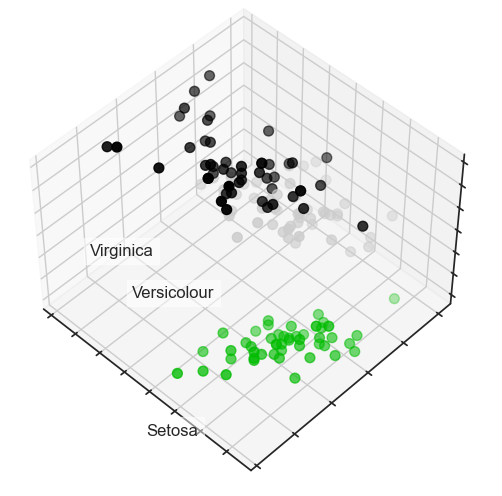

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

# Загрузим данные ирисов
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Создаём трёхмерный график
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Используем add_subplot для создания 3D-осей

# Устанавливаем углы обзора
ax.view_init(elev=48, azim=134)

# Добавляем подписи для каждого класса
for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )

# Меняем порядок цветов меток для визуализации
y_clr = np.choose(y, [1, 2, 0]).astype(np.float64)

# Отображаем точки
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.nipy_spectral, s=50)

# Убираем подписи на осях
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

Теперь посмотрим, насколько PCA улучшит результаты для модели, которая в данном случае плохо справится с классификацией из-за того, что у неё не хватит сложности для описания данных:

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.88889


Теперь попробуем сделать тоже самое, но с данными, для которых мы снизили размерность до 2D:

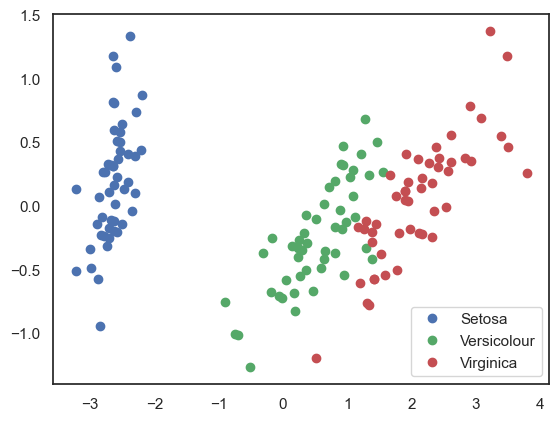

In [ ]:
# Прогоним встроенный в sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], "bo", label="Setosa")
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], "go", label="Versicolour")
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], "ro", label="Virginica")
plt.legend(loc=0);

In [ ]:
# Повторим то же самое разбиение на валидацию и тренировочную выборку.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.91111


Видно, что качество возросло незначительно, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе.

Посмотрим на 2 главные компоненты в последнем PCA-представлении данных и на тот процент исходной дисперсии в даных, который они "объясняют".

In [ ]:
for i, component in enumerate(pca.components_):
    print(
        "{} component: {}% of initial variance".format(
            i + 1, round(100 * pca.explained_variance_ratio_[i], 2)
        )
    )
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Набор данных по рукописным цифрам
Теперь возьмем набор данных по рукописным цифрам. Мы с ним уже работали в 3 [статье](https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist) про деревья решений и метод ближайших соседей.

In [ ]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Вспомним, как выглядят эти цифры – посмотрим на первые десять. Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

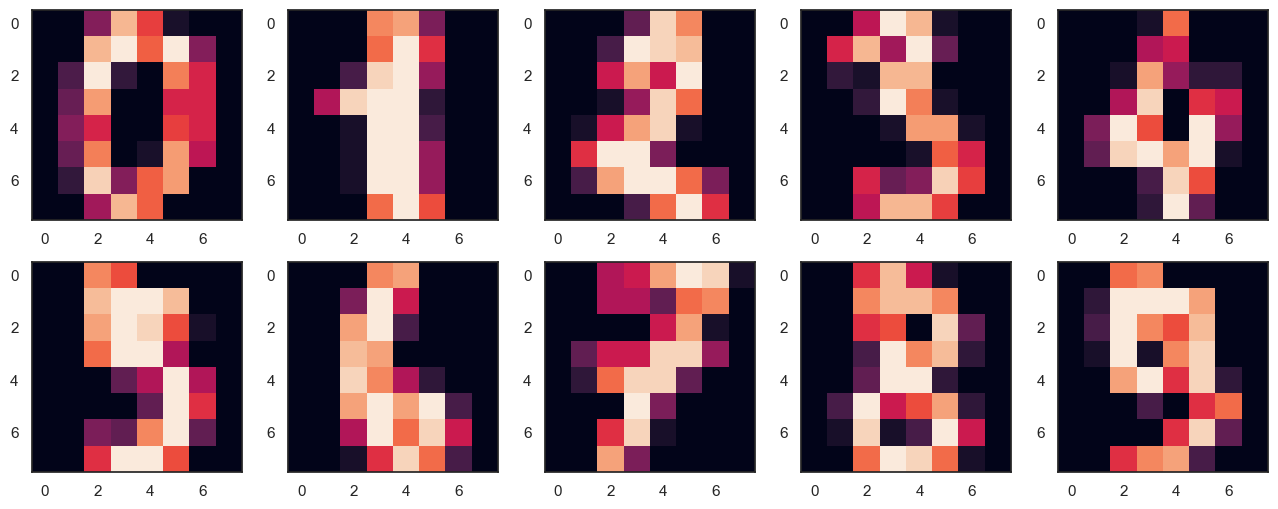

In [ ]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i, :].reshape([8, 8]));

Получается, размерность признакового пространства здесь – 64. Но давайте снизим размерность всего до 2 и увидим, что даже на глаз рукописные цифры неплохо разделяются на кластеры.

Projecting 64-dimensional data to 2D


/tmp/ipykernel_8027/1923420135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


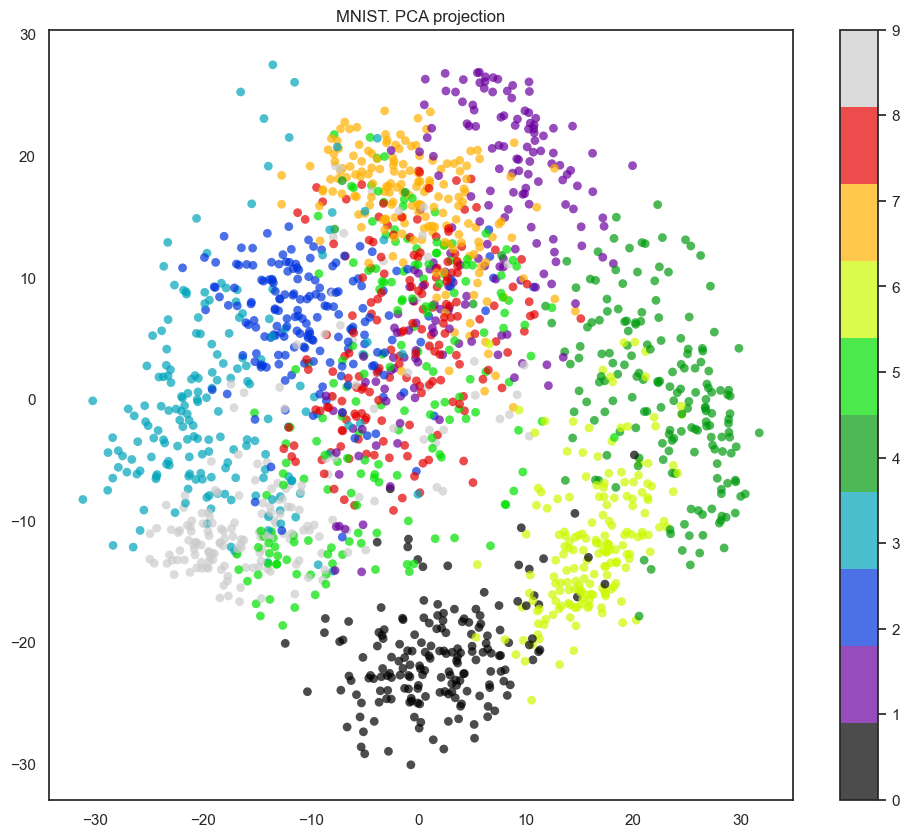

In [ ]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. PCA projection");

Ну, правда, с t-SNE картинка получается еще лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает.

CPU times: user 59.3 s, sys: 68.9 ms, total: 59.4 s
Wall time: 4.28 s


<timed exec>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


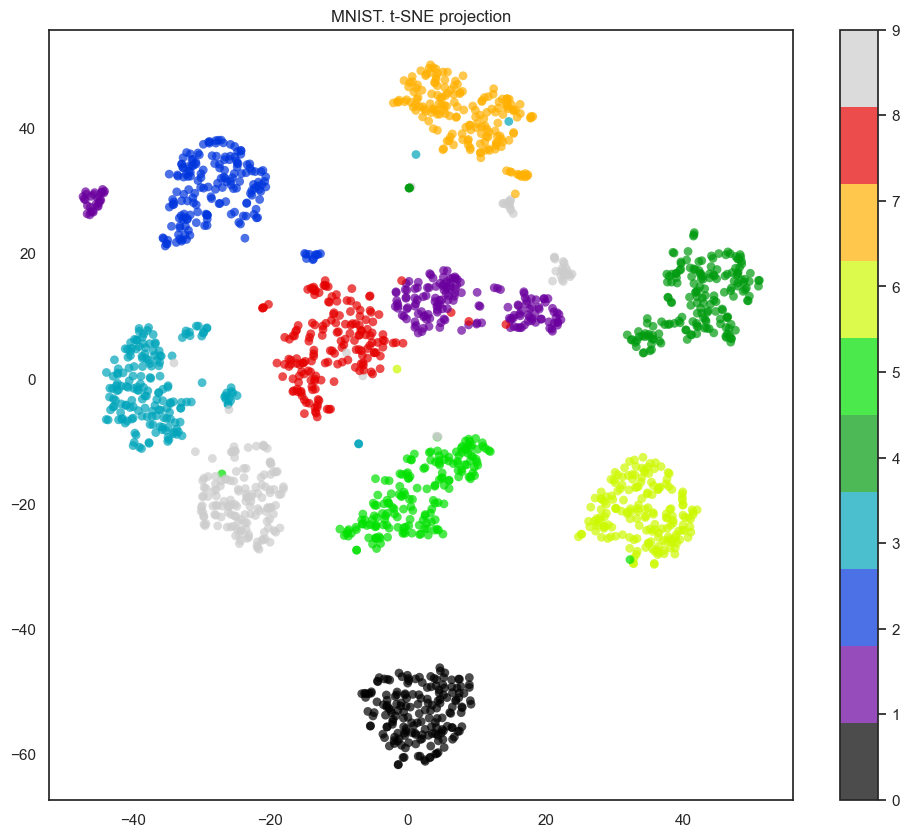

In [ ]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection");

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21.

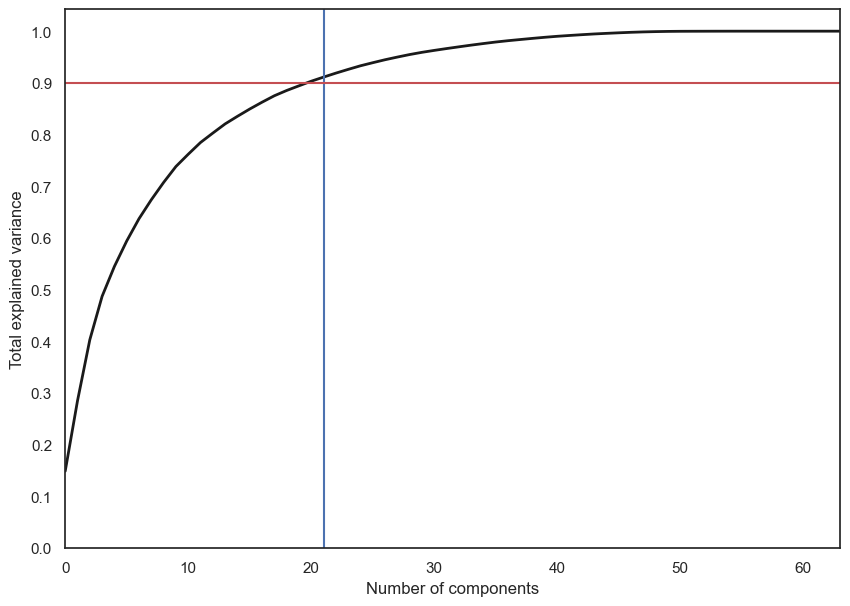

In [ ]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c="b")
plt.axhline(0.9, c="r")
plt.show();